In [1]:
from __future__ import division

import os
import numpy as np
import pandas as pd
from itertools import combinations
from keras.models import load_model
from keras.preprocessing import image
%matplotlib inline
import matplotlib.pylab as plt

Using TensorFlow backend.
/Users/reubenfeinman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from scipy.spatial.distance import cosine

def similarity(x1, x2, measure='cosine'):
    """
    Computes the cosine similarity between two vectors.
    :param x1: (Numpy array) The first vector.
    :param x2: (Numpy array) The second vector.
    :return: (int) The similarity score.
    """
    assert measure in ['cosine', 'euclidean']
    if measure == 'cosine':
        return 1 - cosine(x1, x2)
    else:
        return -np.linalg.norm(x1 - x2)

# Start with generated images

In [5]:
def shift_image(img, scale=30, img_size=(200,200)):
    # compute shape boundaries
    y_min = np.min(np.where(img < 1.)[0])
    y_max = np.max(np.where(img < 1.)[0])
    x_min = np.min(np.where(img < 1.)[1])
    x_max = np.max(np.where(img < 1.)[1])
    # randomly select offsets from a uniform R.V. The boundaries
    # are set such that we don't cut off the object.
    #ox = np.random.randint(low=-x_min, high=img_size[0]-x_max)
    #oy = np.random.randint(low=-y_min, high=img_size[1]-y_max)
    ox = np.random.randint(low=max(-scale, -x_min), high=min(scale, img_size[0]-x_max))
    oy = np.random.randint(low=max(-scale, -y_min), high=min(scale, img_size[1]-y_max))
    # shift the image by offsets
    non = lambda s: s if s<0 else None
    mom = lambda s: max(0,s)
    shift_img = np.ones_like(img, dtype=np.float32)
    shift_img[mom(oy):non(oy), mom(ox):non(ox)] = img[mom(-oy):non(-oy), mom(-ox):non(-ox)]
    
    return shift_img

def load_images(data_folder, target_size=(200, 200), shift=True):
    # First load the images
    files = [file for file in os.listdir(data_folder) if file.endswith('png')]
    files = sorted(files)
    imgs = np.zeros(shape=(len(files),)+target_size+(3,), dtype=np.float32)
    for i, file in enumerate(files):
        img_path = os.path.join(data_folder, file)
        img = image.load_img(img_path, target_size=target_size,
                             interpolation='bicubic')
        img = image.img_to_array(img) / 255.
        if shift:
            img = shift_image(img, img_size=target_size)
        imgs[i] = img
    # Now load the feature info
    feature_file = os.path.join(data_folder, 'data.csv')
    df = pd.read_csv(feature_file, index_col=0)

    return imgs, df

In [6]:
def make_trial(shapes, colors, textures):
    # create a random trial
    ix = np.arange(len(shapes))
    while True:
        baseline = np.random.choice(ix)
        shape = shapes[baseline]
        color = colors[baseline]
        texture = textures[baseline]
        # only matches in shape
        shape_matches = \
        np.where((shapes == shape) &
                 (colors != color) &
                 (textures != texture))[0]
        # only matches in color
        color_matches = \
        np.where((shapes != shape) &
                 (colors == color) &
                 (textures != texture))[0]
        # only matches in texture
        texture_matches = \
        np.where((shapes != shape) &
                 (colors != color) &
                 (textures == texture))[0]

        if len(shape_matches) > 0 and len(color_matches) > 0 and len(
                texture_matches) > 0:
            break  # make sure we have an option for each image...

    shape_match = np.random.choice(shape_matches)
    color_match = np.random.choice(color_matches)
    texture_match = np.random.choice(texture_matches)

    return [baseline, shape_match, color_match, texture_match]

def build_test_trials(test_folder, nb_trials, target_size=(200, 200),
                      shift=True):
    # First, load the images
    imgs, _ = load_images(test_folder, target_size=target_size, shift=shift)
    # Collect the list of shapes, colors and textures
    feature_file = os.path.join(test_folder, 'data.csv')
    df = pd.read_csv(feature_file, index_col=0)
    shapes = df['shape'].as_matrix()
    colors = df['color'].as_matrix()
    textures = df['texture'].as_matrix()

    # Sample the trials
    ix = []
    for i in range(nb_trials):
        ix.extend(make_trial(shapes, colors, textures))
    ix = np.asarray(ix)
    return imgs[ix]

In [16]:
# get a randomly-initialized model

from learning2learn.models import simple_cnn

model = simple_cnn(input_shape=X_generated.shape[1:], nb_classes=5)

## Try w/ original image dataset

In [38]:
data_folder = '../data/images_generated/'
test_folder = os.path.join(data_folder, 'test/')
X_generated = build_test_trials(
    test_folder, nb_trials=1000,
    target_size=(200, 200),
    shift=False,
)

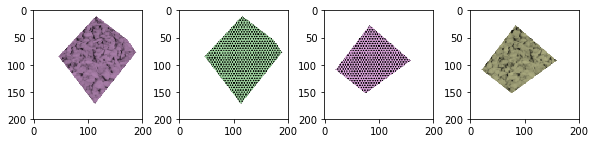

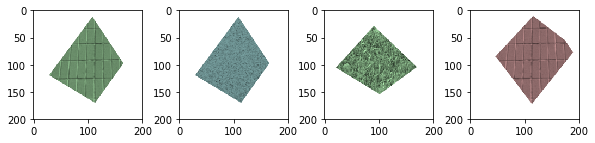

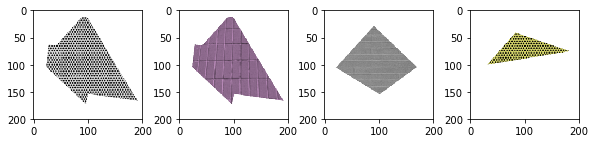

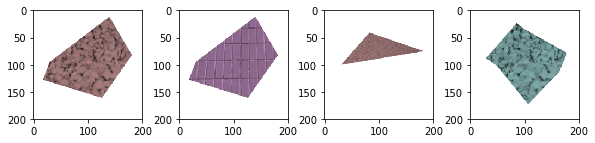

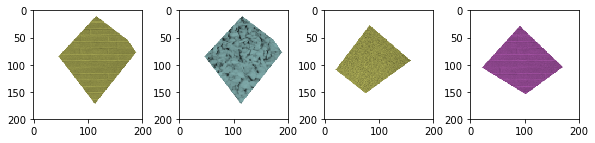

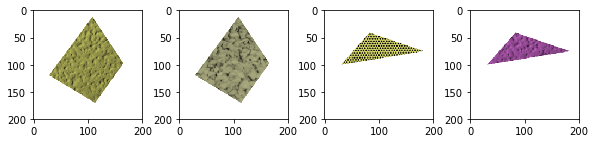

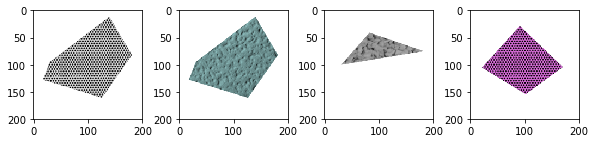

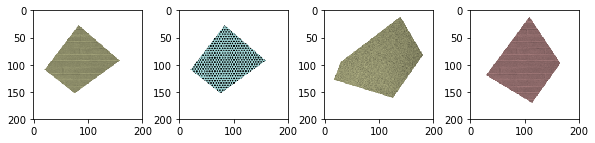

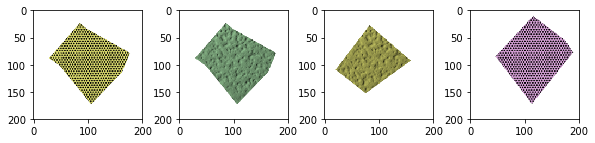

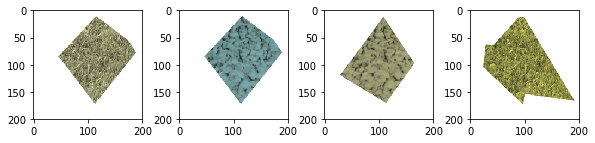

In [39]:
for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,2))
    for j in range(4):
        axes[j].imshow(X_generated[i*4+j])
        #axes[j].set_axis_off()
    plt.show()

In [34]:
def evaluate_secondOrder(X_p, batch_size=32):
    # Since we have groupings of 4 samples, X should have a length that is a
    # multiple of 4.
    assert len(X_p) % 4 == 0
    nb_trials = len(X_p)/4.
    nb_correct = 0
    selections = {0:0, 1:0, 2:0}
    for i in range(int(len(X_p) / 4)):
        score_shape = similarity(X_p[4*i], X_p[4*i+1])
        score_color = similarity(X_p[4*i], X_p[4*i+2])
        score_texture = similarity(X_p[4*i], X_p[4*i+3])
        match = np.argmax([score_shape, score_color, score_texture])
        selections[match] += 1

    # Return the percentage of times we were correct
    return selections[0]/nb_trials, selections[1]/nb_trials, selections[2]/nb_trials

### RGB

In [40]:
X_generated_rgb = X_generated.reshape((len(X_generated), -1))

In [41]:
shape_score, color_score, texture_score = evaluate_secondOrder(X_generated_rgb, batch_size=32)
print('shape score: %0.3f' % shape_score)
print('color score: %0.3f' % color_score)
print('texture score: %0.3f' % texture_score)

shape score: 0.993
color score: 0.004
texture score: 0.003


### Model features

In [42]:
from learning2learn.util import get_hidden_representations

X_generated_hidden = get_hidden_representations(
    model, X_generated, layer_num=-4, batch_size=64
)

In [53]:
shape_score, color_score, texture_score = evaluate_secondOrder(X_generated_hidden, batch_size=32)
print('shape score: %0.3f' % shape_score)
print('color score: %0.3f' % color_score)
print('texture score: %0.3f' % texture_score)

shape score: 0.803
color score: 0.066
texture score: 0.131


## Try again w/ new image dataset

In [19]:
data_folder = '../data/images_generated2/'
test_folder = os.path.join(data_folder, 'test/')
X_generated = build_test_trials(
    test_folder, nb_trials=1000,
    target_size=(200, 200),
    shift=False,
)

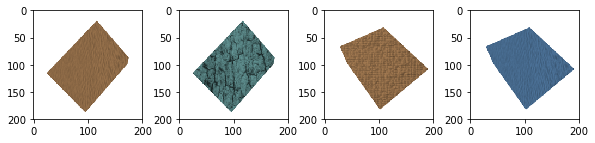

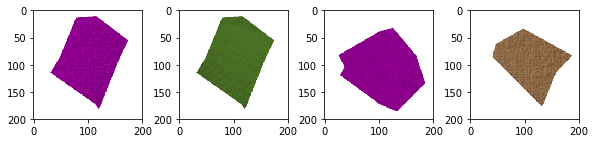

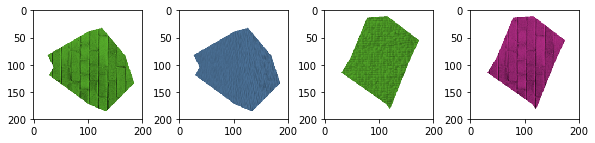

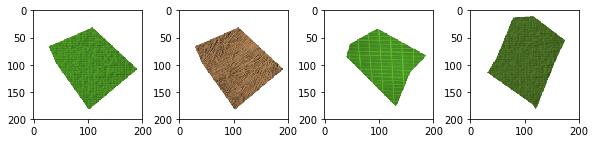

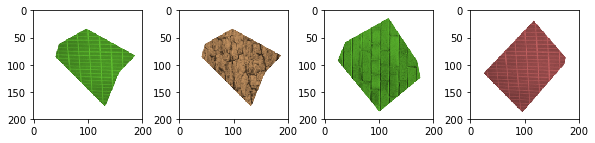

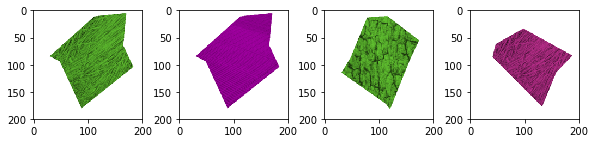

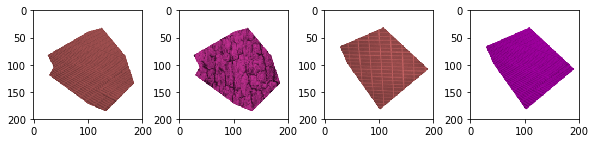

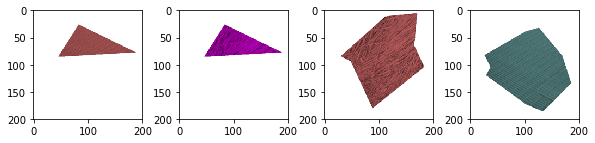

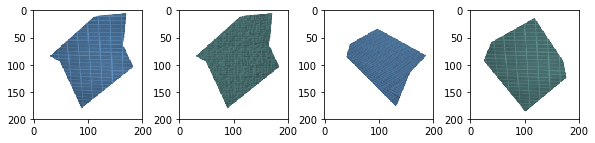

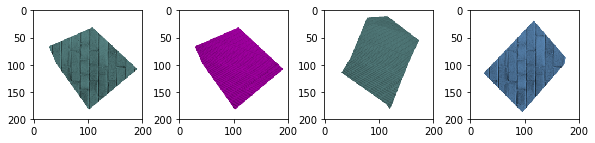

In [20]:
for i in range(10):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,2))
    for j in range(4):
        axes[j].imshow(X_generated[i*4+j])
        #axes[j].set_axis_off()
    plt.show()

### RGB

In [21]:
X_generated_rgb = X_generated.reshape((len(X_generated), -1))

In [36]:
shape_score, color_score, texture_score = evaluate_secondOrder(X_generated_rgb, batch_size=32)
print('shape score: %0.3f' % shape_score)
print('color score: %0.3f' % color_score)
print('texture score: %0.3f' % texture_score)

shape score: 0.963
color score: 0.027
texture score: 0.010


### Model features

In [23]:
X_generated_hidden = get_hidden_representations(
    model, X_generated, layer_num=-4, batch_size=64
)

In [37]:
shape_score, color_score, texture_score = evaluate_secondOrder(X_generated_hidden, batch_size=32)
print('shape score: %0.3f' % shape_score)
print('color score: %0.3f' % color_score)
print('texture score: %0.3f' % texture_score)

shape score: 0.954
color score: 0.037
texture score: 0.009


In [19]:
# def evaluate_secondOrder1(X, X_p, metric='cosine'):
#     # Since we have groupings of 4 samples, X should have a length that is a
#     # multiple of 4.
#     assert len(X) == len(X_p)
#     assert len(X) % 4 == 0
    
#     scores_shape = []
#     scores_color = []
#     scores_texture = []
#     for i in range(int(len(X) / 4)):
#         scores_shape.append(similarity(X_p[4*i], X_p[(4*i)+1], metric))
#         scores_color.append(similarity(X_p[4*i], X_p[(4*i)+2], metric))
#         scores_texture.append(similarity(X_p[4*i], X_p[(4*i)+3], metric))

#     # Return the percentage of times we were correct
#     return np.asarray(scores_shape), np.asarray(scores_color), np.asarray(scores_texture)

In [20]:
# scores_shape, scores_color, scores_texture = evaluate_secondOrder1(X_generated, X_generated_hidden)

In [23]:
# print('shape score: %0.3f' % scores_shape.mean())
# print('color score: %0.3f' % scores_color.mean())
# print('texture score: %0.3f' % scores_texture.mean())

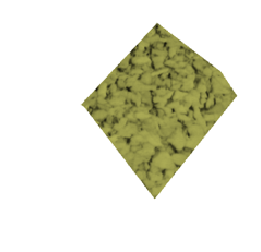

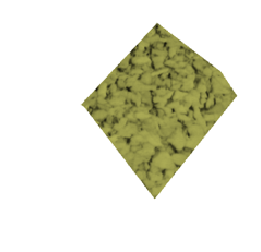

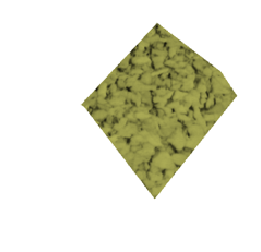

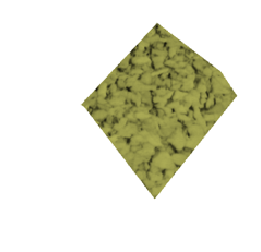

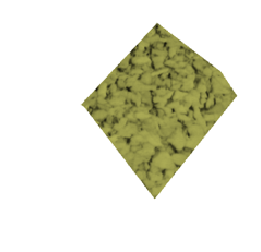

In [131]:
for i in range(5):
    plt.figure()
    plt.imshow(X_generated[0])
    plt.axis('off')
    plt.show()

In [106]:
def show_trials(X, X_p, groups):
    
    for group in groups:
        print('\n\n')
        # baseline
        plt.figure(figsize=(3,3))
        plt.imshow(X[group[0]])
        plt.axis('off')
        plt.show()
        # 3 candidates
        fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(8,3))
        axes[0].imshow(X[group[1]])
        axes[0].axis('off')
        axes[1].imshow(X[group[2]])
        axes[1].axis('off')
        axes[2].imshow(X[group[3]])
        axes[2].axis('off')
        plt.show()
        print('shape match similarity: %0.3f' % similarity(X_p[group[0]], X_p[group[1]]))
        print('color match similarity: %0.3f' % similarity(X_p[group[0]], X_p[group[2]]))
        print('texture match similarity: %0.3f' % similarity(X_p[group[0]], X_p[group[3]]))

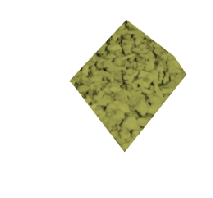

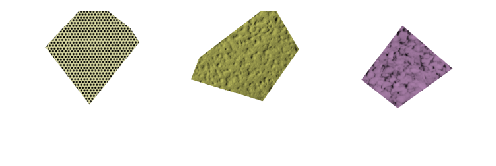

shape match similarity: 0.946
color match similarity: 0.955
texture match similarity: 0.958





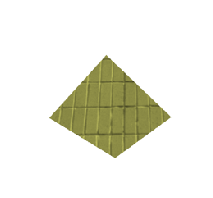

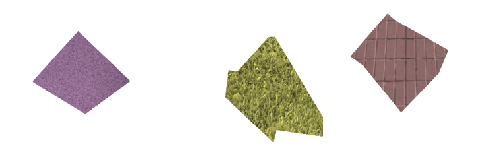

shape match similarity: 0.969
color match similarity: 0.959
texture match similarity: 0.944





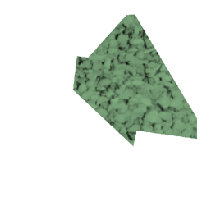

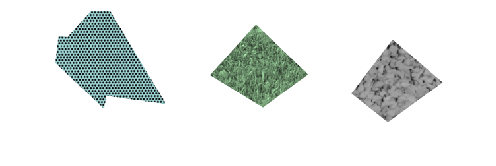

shape match similarity: 0.962
color match similarity: 0.971
texture match similarity: 0.943





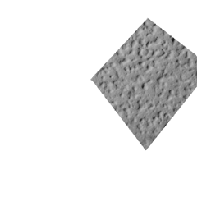

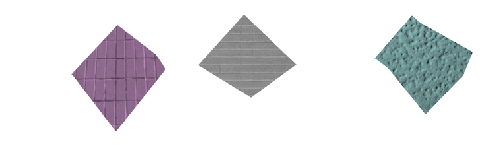

shape match similarity: 0.984
color match similarity: 0.956
texture match similarity: 0.972





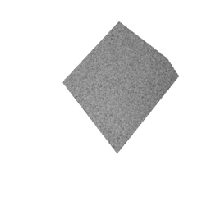

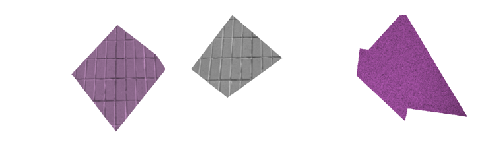

shape match similarity: 0.974
color match similarity: 0.965
texture match similarity: 0.956





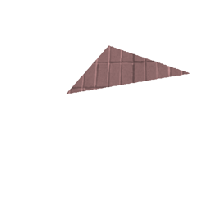

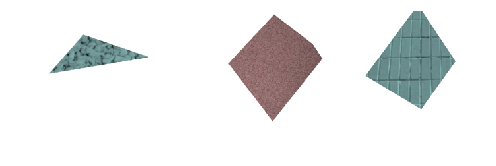

shape match similarity: 0.990
color match similarity: 0.966
texture match similarity: 0.974





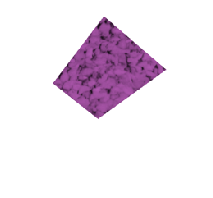

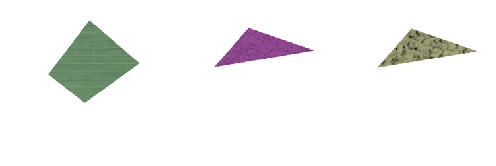

shape match similarity: 0.985
color match similarity: 0.975
texture match similarity: 0.972





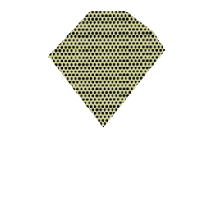

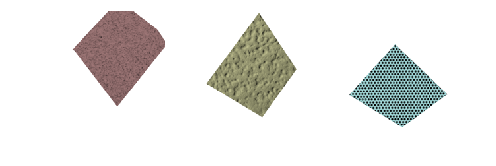

shape match similarity: 0.938
color match similarity: 0.954
texture match similarity: 0.924





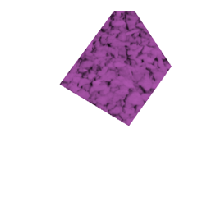

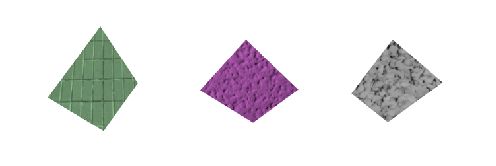

shape match similarity: 0.948
color match similarity: 0.948
texture match similarity: 0.955





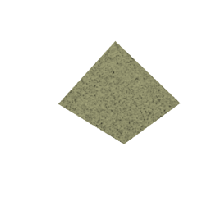

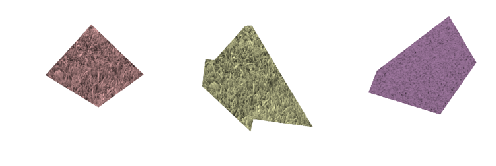

shape match similarity: 0.978
color match similarity: 0.968
texture match similarity: 0.978





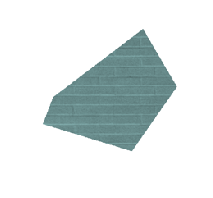

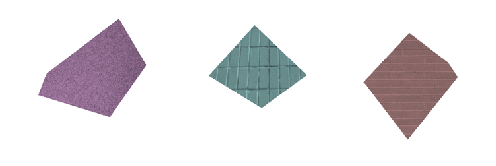

shape match similarity: 0.983
color match similarity: 0.974
texture match similarity: 0.976





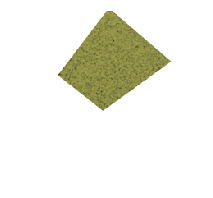

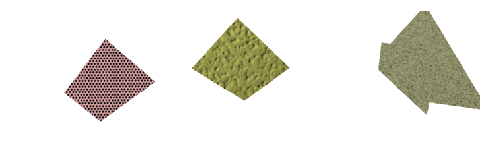

shape match similarity: 0.942
color match similarity: 0.970
texture match similarity: 0.969





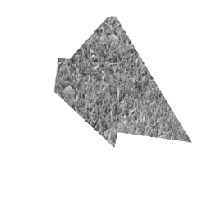

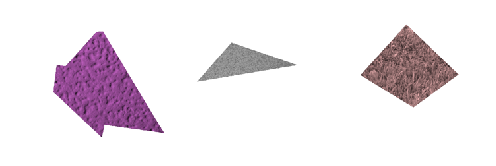

shape match similarity: 0.959
color match similarity: 0.970
texture match similarity: 0.979





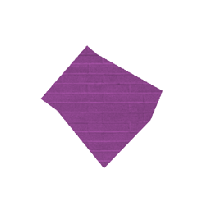

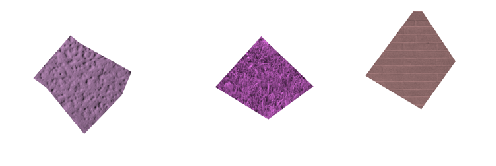

shape match similarity: 0.988
color match similarity: 0.965
texture match similarity: 0.954





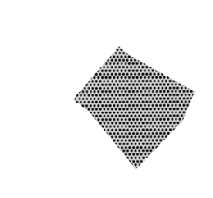

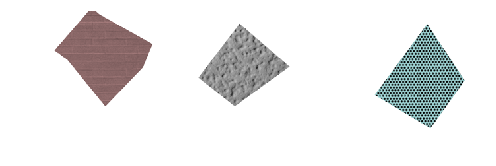

shape match similarity: 0.937
color match similarity: 0.952
texture match similarity: 0.968





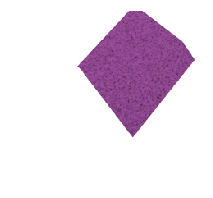

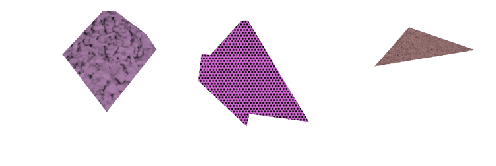

shape match similarity: 0.983
color match similarity: 0.910
texture match similarity: 0.964





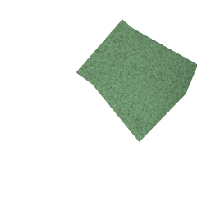

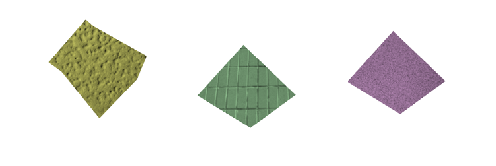

shape match similarity: 0.959
color match similarity: 0.938
texture match similarity: 0.944





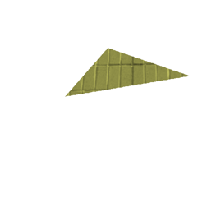

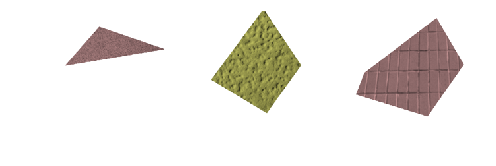

shape match similarity: 0.980
color match similarity: 0.968
texture match similarity: 0.962





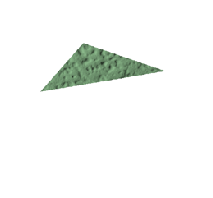

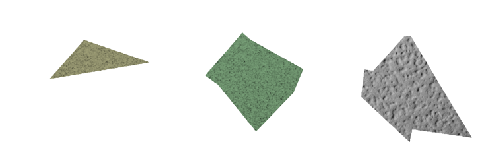

shape match similarity: 0.992
color match similarity: 0.962
texture match similarity: 0.958





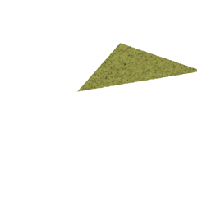

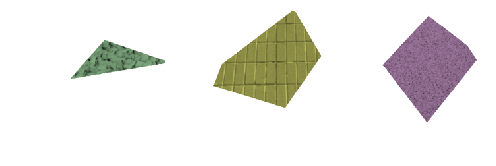

shape match similarity: 0.993
color match similarity: 0.961
texture match similarity: 0.971





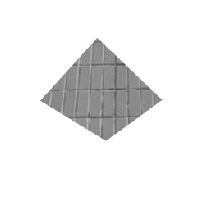

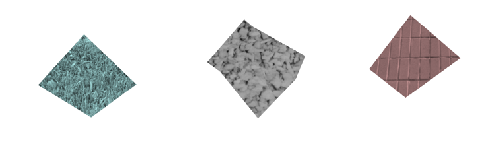

shape match similarity: 0.995
color match similarity: 0.978
texture match similarity: 0.972





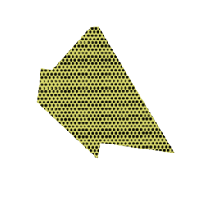

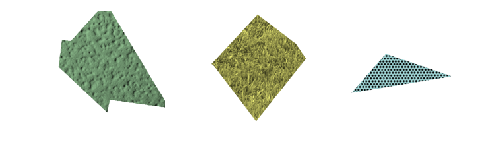

shape match similarity: 0.913
color match similarity: 0.930
texture match similarity: 0.938





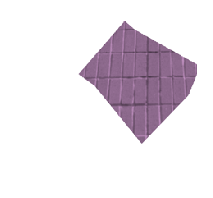

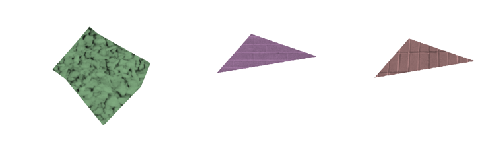

shape match similarity: 0.962
color match similarity: 0.973
texture match similarity: 0.972





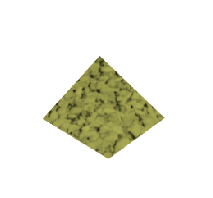

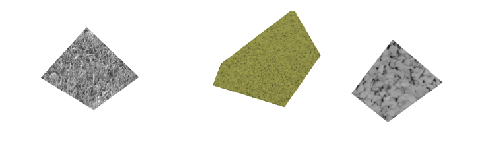

shape match similarity: 0.964
color match similarity: 0.941
texture match similarity: 0.979





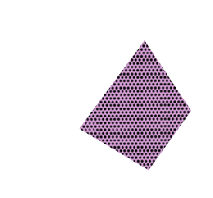

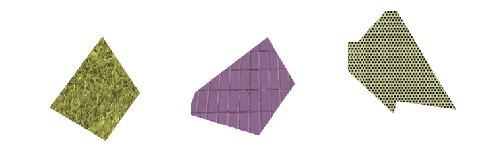

shape match similarity: 0.945
color match similarity: 0.941
texture match similarity: 0.905





IndexError: index 100 is out of bounds for axis 0 with size 100

In [112]:
groups_gen = [list(range(i*4, (i+1)*4)) for i in range(int(len(X_generated)/4))]
show_trials(X_generated[:100], X_generated_rgb[:100], groups_gen)

In [8]:
def evaluate_secondOrder1(X_p, groups, metric='cosine'):
    
    nb_correct = 0
    for group in groups:
        score_shape = similarity(X_p[group[0]], X_p[group[1]], metric)
        score_color = similarity(X_p[group[0]], X_p[group[2]], metric)
        score_texture = similarity(X_p[group[0]], X_p[group[3]], metric)
        if score_shape > score_color and score_shape > score_texture:
            nb_correct += 1

    # Return the percentage of times we were correct
    return nb_correct / len(groups)

In [51]:
evaluate_secondOrder1(X_generated_rgb, groups_gen)

0.88

In [49]:
len(groups_gen)

50

# Now try with artist images

In [75]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from scipy.misc import imread

def load_artist_imgs(save_folder, target_size):
    shapes = []
    colors = []
    textures = []
    imgs = []
    files = [file for file in os.listdir(save_folder) if file.endswith('jpg') or file.endswith('png')]
    for file in files:
        shape, texture, color = file.split('_')
        color = color[:-4]
        shapes.append(shape)
        textures.append(texture)
        colors.append(color)
        img_path = os.path.join(save_folder, file)
        img = image.load_img(img_path, target_size=target_size, interpolation='bicubic')
        imgs.append(image.img_to_array(img))
        #img = (imread(img_path)[:,:,:3]).astype(np.float32)
        #imgs.append(img)
        
    le = LabelEncoder()
    shapes = le.fit_transform(shapes)
    colors = le.fit_transform(colors)
    textures = le.fit_transform(textures)
    
    imgs = np.asarray(imgs)
    #imgs /= 255.
    return imgs, shapes, colors, textures

In [76]:
data_folder = '../data/images_artist/'
X_artist, shapes_artist, colors_artist, textures_artist = load_artist_imgs(data_folder, target_size=(200, 200))
X_artist_rgb = X_artist.reshape((len(X_artist), -1))

In [77]:
def find_match(i, idx, others1, others2):
    idx = np.random.permutation(idx)
    for j in idx:
        if not (others1[i] == others1[j] or others2[i] == others2[j]):
            return j
    print('Failed for ind %i.' % i)
    return -1

def get_group(i, shapes, colors, textures):
    idx_s = list(np.where(shapes == shapes[i])[0])
    idx_c = list(np.where(colors == colors[i])[0])
    idx_t = list(np.where(textures == textures[i])[0])
    idx_s.remove(i)
    idx_c.remove(i)
    idx_t.remove(i)
    i_s = find_match(i, idx_s, colors, textures)
    i_c = find_match(i, idx_c, textures, shapes)
    i_t = find_match(i, idx_t, shapes, colors)
    return [i, i_s, i_c, i_t]
    
def get_groups(shapes, colors, textures):
    groups = []
    for i in range(len(shapes)):
        # 6 is the 'x' texture... ignore those
        if textures[i] == 6:
            continue
        group = get_group(i, shapes, colors, textures)
        if not -1 in group:
            groups.append(group)
    
    return np.asarray(groups)

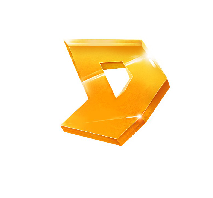

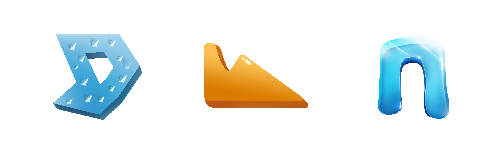

shape match similarity: 0.949
color match similarity: 0.954
texture match similarity: 0.938





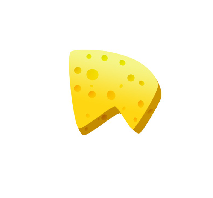

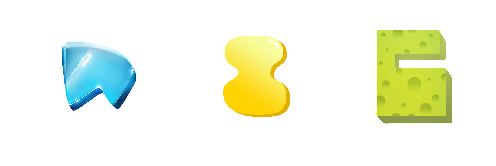

shape match similarity: 0.964
color match similarity: 0.984
texture match similarity: 0.974





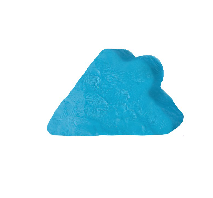

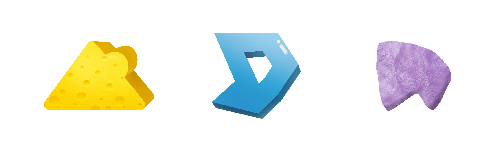

shape match similarity: 0.923
color match similarity: 0.972
texture match similarity: 0.965





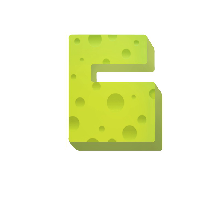

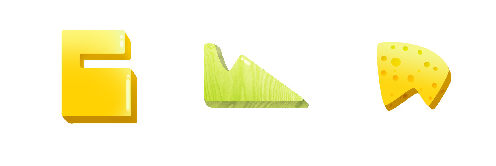

shape match similarity: 0.993
color match similarity: 0.966
texture match similarity: 0.974





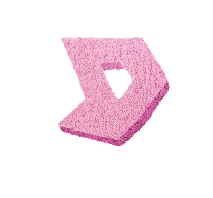

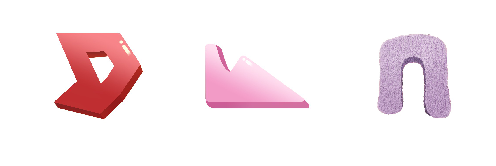

shape match similarity: 0.981
color match similarity: 0.988
texture match similarity: 0.990





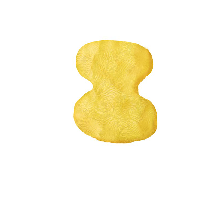

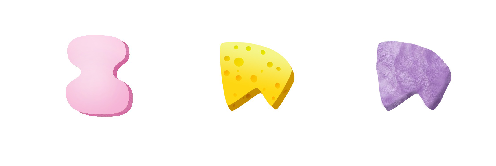

shape match similarity: 0.985
color match similarity: 0.984
texture match similarity: 0.977





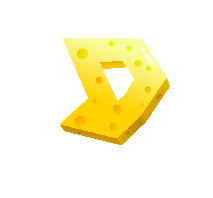

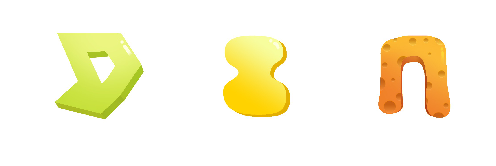

shape match similarity: 0.996
color match similarity: 0.986
texture match similarity: 0.973





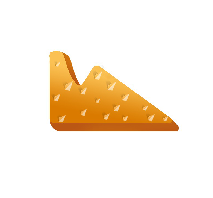

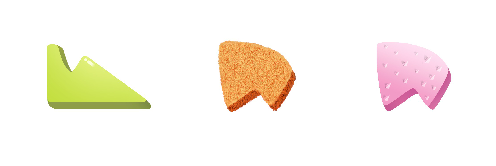

shape match similarity: 0.991
color match similarity: 0.968
texture match similarity: 0.970





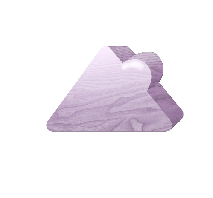

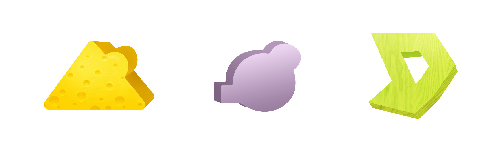

shape match similarity: 0.966
color match similarity: 0.993
texture match similarity: 0.975





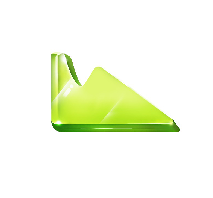

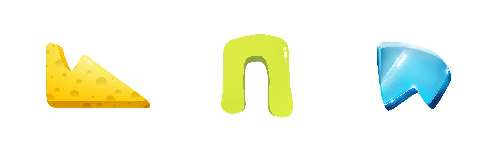

shape match similarity: 0.992
color match similarity: 0.969
texture match similarity: 0.962





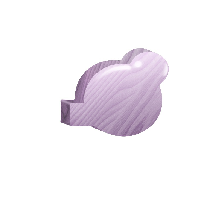

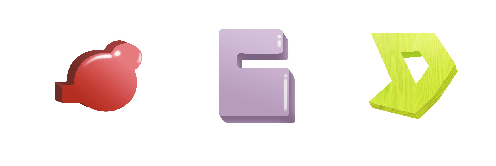

shape match similarity: 0.983
color match similarity: 0.987
texture match similarity: 0.976





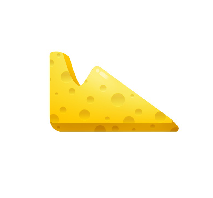

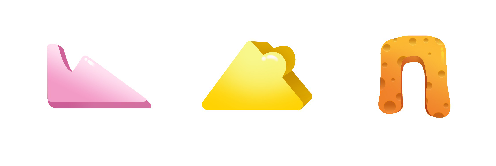

shape match similarity: 0.981
color match similarity: 0.977
texture match similarity: 0.959





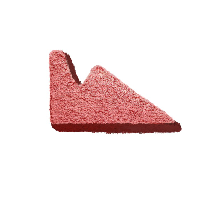

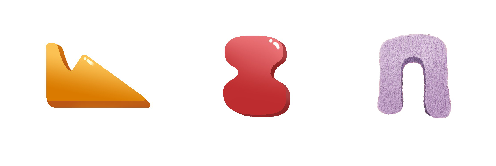

shape match similarity: 0.989
color match similarity: 0.956
texture match similarity: 0.965





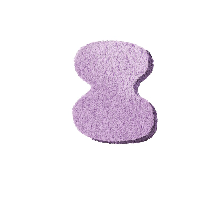

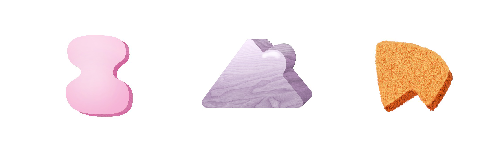

shape match similarity: 0.995
color match similarity: 0.988
texture match similarity: 0.977





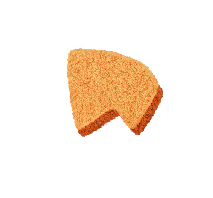

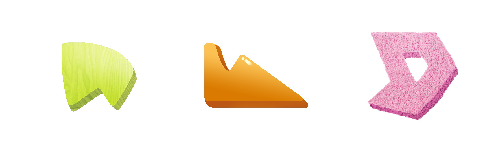

shape match similarity: 0.993
color match similarity: 0.968
texture match similarity: 0.981





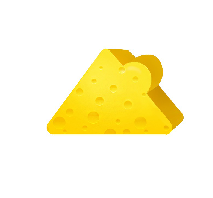

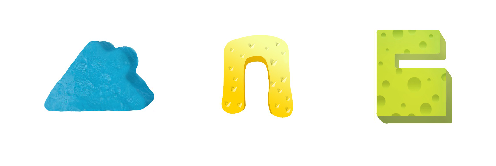

shape match similarity: 0.923
color match similarity: 0.972
texture match similarity: 0.965





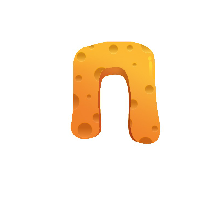

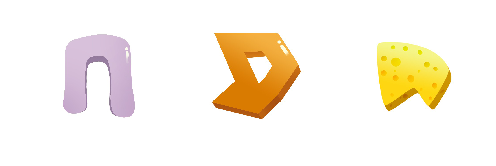

shape match similarity: 0.980
color match similarity: 0.970
texture match similarity: 0.978





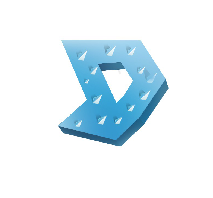

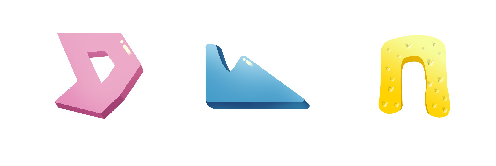

shape match similarity: 0.982
color match similarity: 0.971
texture match similarity: 0.958





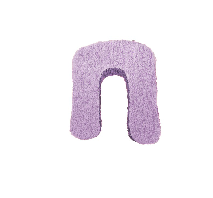

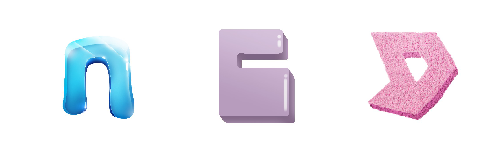

shape match similarity: 0.988
color match similarity: 0.988
texture match similarity: 0.990





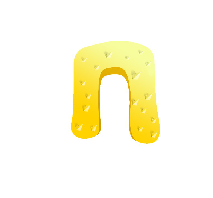

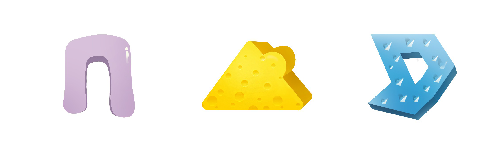

shape match similarity: 0.984
color match similarity: 0.972
texture match similarity: 0.958





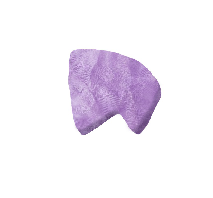

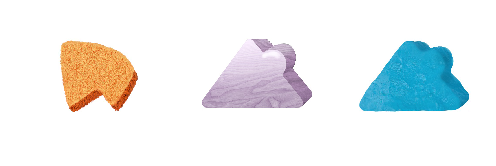

shape match similarity: 0.985
color match similarity: 0.989
texture match similarity: 0.965





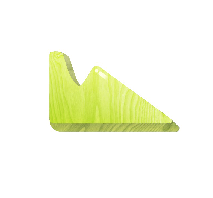

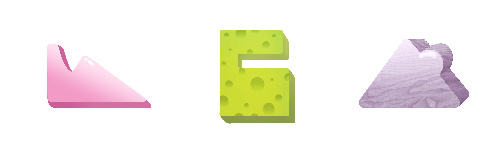

shape match similarity: 0.989
color match similarity: 0.966
texture match similarity: 0.984





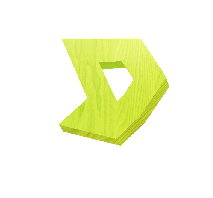

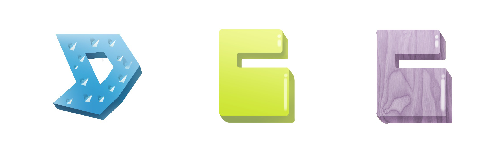

shape match similarity: 0.968
color match similarity: 0.985
texture match similarity: 0.973





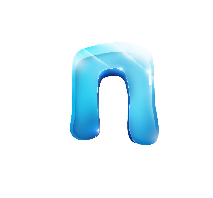

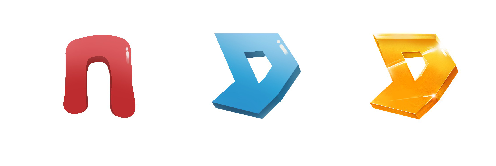

shape match similarity: 0.959
color match similarity: 0.975
texture match similarity: 0.938





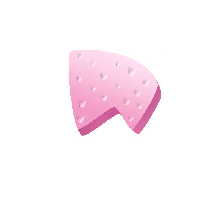

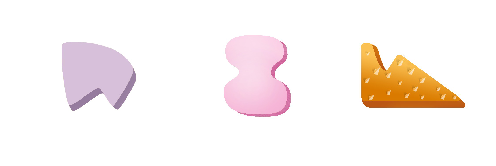

shape match similarity: 0.999
color match similarity: 0.995
texture match similarity: 0.970





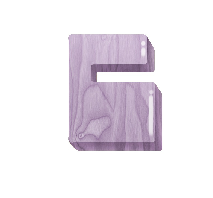

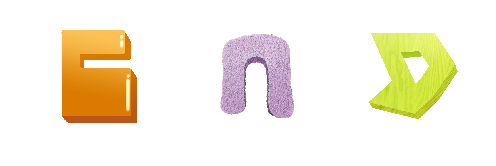

shape match similarity: 0.967
color match similarity: 0.987
texture match similarity: 0.973





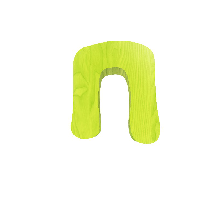

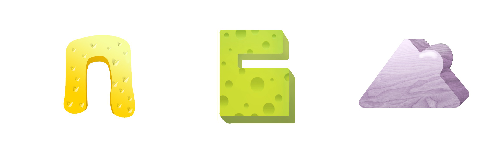

shape match similarity: 0.996
color match similarity: 0.977
texture match similarity: 0.974





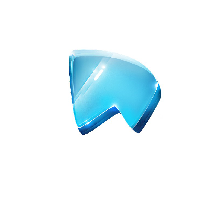

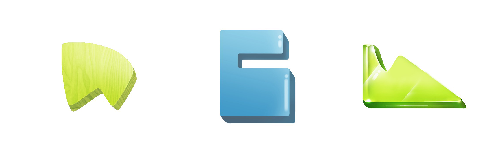

shape match similarity: 0.977
color match similarity: 0.975
texture match similarity: 0.962





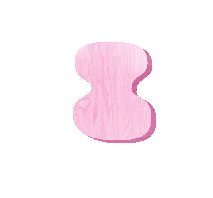

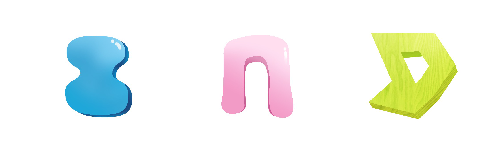

shape match similarity: 0.977
color match similarity: 0.996
texture match similarity: 0.977





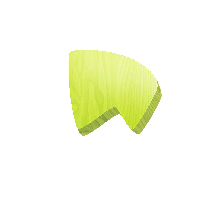

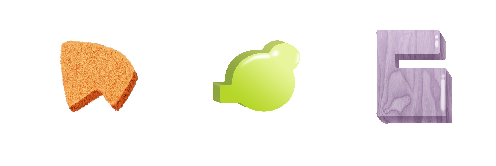

shape match similarity: 0.993
color match similarity: 0.990
texture match similarity: 0.979


In [35]:
groups_art = get_groups(shapes_artist, colors_artist, textures_artist)
show_trials(X_artist, X_artist_rgb, groups_art)

In [78]:
evaluate_secondOrder1(X_artist_rgb, groups_art)

0.5666666666666667

In [72]:
def evaluate_secondOrder2(X_p, groups, metric='cosine'):
    
    shape_scores = np.zeros(len(groups))
    color_scores = np.zeros(len(groups))
    texture_scores = np.zeros(len(groups))
    for i, group in enumerate(groups):
        shape_scores[i] = similarity(X_p[group[0]], X_p[group[1]], metric)
        color_scores[i] = similarity(X_p[group[0]], X_p[group[2]], metric)
        texture_scores[i] = similarity(X_p[group[0]], X_p[group[3]], metric)

    return shape_scores, color_scores, texture_scores

In [79]:
shape_scores, color_scores, texture_scores = evaluate_secondOrder2(X_artist_rgb, groups_art)
print('shape avg score: %0.3f' % shape_scores.mean())
print('color avg score: %0.3f' % color_scores.mean())
print('texture avg score: %0.3f' % texture_scores.mean())

shape avg score: 0.979
color avg score: 0.979
texture avg score: 0.971


In [80]:
shape_scores, color_scores, texture_scores = evaluate_secondOrder2(X_artist_rgb, groups_art, 'euclidean')
print('shape avg score: %0.3f' % shape_scores.mean())
print('color avg score: %0.3f' % color_scores.mean())
print('texture avg score: %0.3f' % texture_scores.mean())

shape avg score: -15668.390
color avg score: -16402.342
texture avg score: -19791.593


In [140]:
#X_artist_hidden = get_hidden_representations(model_ca05_ex00, X_artist, layer_num=-4, batch_size=64)

In [6]:
# def compute_avg_similarity(X_h, target, other1, other2):
#     scores = []
#     for cat in set(target):
#         print('Collecting scores for category #%i' % cat)
#         # Find indices of samples with this category
#         inds = list(np.where(target == cat)[0])
#         scores_cat = []
#         for i, j in combinations(inds, 2):
#             assert target[i] == target[j]
#             if not (other1[i] == other1[j] or other2[i] == other2[j]):
#                 scores_cat.append(similarity(X_h[i], X_h[j]))
#         print('# scores for this category: %i' % len(scores_cat))
#         scores.extend(scores_cat)
    
#     return np.mean(scores)

# def accuracy_for_layer(X_h, shapes, colors, textures, normalize=True):
#     # Loop through the samples and compute accuracy
#     print('Computing shape scores...')
#     sim_shape = compute_avg_similarity(X_h, target=shapes, other1=colors, other2=textures)
#     print('\nComputing color scores...')
#     sim_color = compute_avg_similarity(X_h, target=colors, other1=shapes, other2=textures)
#     print('\nComputing texture scores...')
#     sim_texture = compute_avg_similarity(X_h, target=textures, other1=colors, other2=shapes)
#     print('\n')
    
#     similarities = [sim_shape, sim_color, sim_texture]
#     if normalize:
#         similarities /= np.sum(similarities)
#     return similarities

In [9]:
# sim_shape_artist, sim_color_artist, sim_texture_artist = accuracy_for_layer(
#     X_artist_hidden, shapes_artist, colors_artist, textures_artist, normalize=False
# )
# print('shape score: %0.3f' % sim_shape_artist)
# print('color score: %0.3f' % sim_color_artist)
# print('texture score: %0.3f' % sim_texture_artist)

In [42]:
def compute_avg_similarity(X_p, target, other1, other2, metric='cosine'):
    scores = []
    for cat in set(target):
        #print('Collecting scores for category #%i' % cat)
        # Find indices of samples with this category
        inds = list(np.where(target == cat)[0])
        scores_cat = []
        for i, j in combinations(inds, 2):
            assert target[i] == target[j]
            if not (other1[i] == other1[j] or other2[i] == other2[j]):
                scores_cat.append(similarity(X_p[i], X_p[j], metric))
        #print('# scores for this category: %i' % len(scores_cat))
        scores.extend(scores_cat)
    
    return np.mean(scores)

In [45]:
shape_avg_score_rgb = compute_avg_similarity(X_artist_rgb, shapes_artist, colors_artist, textures_artist)
color_avg_score_rgb = compute_avg_similarity(X_artist_rgb, colors_artist, textures_artist, shapes_artist)
texture_avg_score_rgb = compute_avg_similarity(X_artist_rgb, textures_artist, shapes_artist, colors_artist)
print('shape avg score: %0.3f' % shape_avg_score_rgb)
print('color avg score: %0.3f' % color_avg_score_rgb)
print('texture avg score: %0.3f' % texture_avg_score_rgb)

shape avg score: 0.981
color avg score: 0.979
texture avg score: 0.967


In [46]:
shape_avg_score_rgb = compute_avg_similarity(X_artist_rgb, shapes_artist, colors_artist, textures_artist, 'euclidean')
color_avg_score_rgb = compute_avg_similarity(X_artist_rgb, colors_artist, textures_artist, shapes_artist, 'euclidean')
texture_avg_score_rgb = compute_avg_similarity(X_artist_rgb, textures_artist, shapes_artist, colors_artist, 'euclidean')
print('shape avg score: %0.3f' % shape_avg_score_rgb)
print('color avg score: %0.3f' % color_avg_score_rgb)
print('texture avg score: %0.3f' % texture_avg_score_rgb)

shape avg score: -59.361
color avg score: -64.201
texture avg score: -82.230


# Figure out Subhankar code

In [ ]:
# -- function and variable definitions -- #

def import_images(directory, create_pdfs=False):

	print('importing images...')
	vectors = []
	for path, subdirs, files in os.walk(directory):
		for name in files:
			if not name.startswith('.'):
				vectors.append((name.split('.')[0]).split('_') +  
								[mpimg.imread(os.path.join(path, name))] +
								[path, name])

	if (create_pdfs == True):
		pdfs = []
		print('Generating PDFs to store results...')
		for tensor in tensor_names:
			pdfs.append([PdfPages('shape_bias_' + (tensor.split('/')[0]).split(':')[0] + '_correct.pdf'),
							PdfPages('shape_bias_' + tensor.split('/')[0].split(':')[0] + '_wrong.pdf')])
		print('done')
		return (vectors, pdfs)
	else:
		print('done')
		return vectors
    
    
def generate_vectors_alexnet(images = [], layers = []):
	# returns raw image + representation of each layer
	vectors = {}
	print('generating intermediate representations...')
	with tf.Session() as sess:
		sess.run(init)
		for image in images:
			image_data = (imread(os.path.join(image[-2], image[-1]))[:,:,:3]).astype(float32)
			norm_image_data = image_data - mean(image_data)
			# using `eval(x)' since the code was written to assign python variables a tensor
			image_vec = [np.squeeze(tensor.flatten()) for 
                         tensor in sess.run([eval(layer) for layer in layers], {x: [norm_image_data]})]
			raw_image = (imread(os.path.join(image[-2], image[-1]))[:,:,:3])
			vectors[image[-1]] = [np.squeeze(raw_image.flatten())] + image_vec
	print('done')
	return(vectors)